In [257]:
import numpy as np
import pyshtools as pysh
import RFmod as RF
import SLmod as SL
import xarray as xr
import slsolver as sls

from numpy import pi as pi

In [252]:
## Preliminaries

L = 63
lmax=10
Q = RF.sobolev_covariance(L, s=2, mu=0.2)
rhow = SL.rhow

# read in the present day sea level and ice thickness
sl0,ice0 = SL.get_sl_ice_data(L)
C = SL.ocean_function(sl0,ice0)

## The action of A

In [216]:
## For the input to our function, we would like a vector formed by reshaping a gridded direct load, zeta

zeta_glq = -rhow*RF.random_field(Q)
zeta_gr = -rhow*RF.random_field(Q).to_array()
zeta_vec = zeta_gr.reshape(-1)

In [147]:
## Version of the function which just uses a normal GLQRealGrid as input

def potential0(zeta_glq, L, lmax=10):

    ## Solve the sea level equation
    _,_,solution,_,_ = SL.fingerprint(C, zeta_glq)

    ## Expand the solution in spherical harmonics. Clm = solution[0,l,m] and Slm = solution[1,l,m]
    coeffs = pysh.expand.SHExpandGLQ(solution.to_array(),lmax_calc=lmax)

    ## Populate a vector (1-D np array) with the expanded coefficients, in ascending order of l (2<=l<=lmax), doing Clm in reverse order then Slm in standard order for each l
    coeffs_vec = np.zeros(((lmax+1)**2)-4)
    
    for l in range(2,lmax+1):
        coeffs_vec[((l)**2)-4:((l+1)**2)-4] = np.concatenate((coeffs[1,l,1:l+1][::-1],coeffs[0,l,0:l+1]))
    
    return coeffs_vec

In [162]:
## Full version of the function

def potential(zeta_vec, L, lmax=10):

    ## Convert zeta to a GLQGrid
    zeta_glq = pysh.SHGrid.from_array(zeta_vec.reshape(L+1,2*(L+1)),grid='GLQ')

    ## Solve the sea level equation
    _,_,solution,_,_ = SL.fingerprint(C, zeta_glq)

    ## Expand the solution in spherical harmonics. Clm = solution[0,l,m] and Slm = solution[1,l,m]
    coeffs = pysh.expand.SHExpandGLQ(solution.to_array(),lmax_calc=lmax)

    ## Populate a vector (1-D np array) with the expanded coefficients, in ascending order of l (2<=l<=lmax), doing Clm in reverse order then Slm in standard order for each l
    coeffs_vec = np.zeros(((lmax+1)**2)-4)
    
    for l in range(2,lmax+1):
        coeffs_vec[((l)**2)-4:((l+1)**2)-4] = np.concatenate((coeffs[1,l,1:l+1][::-1],coeffs[0,l,0:l+1]))
    
    return coeffs_vec


## The action of A* on an arbitray vector, phi'

In [214]:
## First make an arbitrary field, phi'

phi_glq = RF.random_field(Q)
phi_gr = phi_glq.to_array()
phi_vec = phi_gr.reshape(-1)

def potential_adjoint(phi_vec, L, lmax=10):

    ## Convert phi to a GLQGrid
    phi_glq = pysh.SHGrid.from_array(phi_vec.reshape(L+1,2*(L+1)),grid='GLQ')

    ## Define a null vector (representing phi_d and phu_u_d)
    null = phi_glq - phi_glq

    ## Find zeta_phi_d by scaling phi with -g/b^2, where b is the radius of the earth
    zeta_phi_d = -SL.g/SL.b**2*phi_glq

    ## Then find k_d
    kk_d = SL.rotation_vector_from_zeta_psi(zeta_phi_d)

    ## Now solve the adjoint fingerprint problem
    sl_d,_,_,_,_ = SL.generalised_fingerprint(C,null, null, zeta_phi_d, kk_d)

    ## Expand the solution in spherical harmonics. Clm = solution[0,l,m] and Slm = solution[1,l,m]
    coeffs = pysh.expand.SHExpandGLQ(sl_d.to_array(),lmax_calc=lmax)

    ## Populate a vector (1-D np array) with the expanded coefficients, in ascending order of l (2<=l<=lmax), doing Clm in reverse order then Slm in standard order for each l
    coeffs_vec = np.zeros(((lmax+1)**2)-4)
    
    for l in range(2,lmax+1):
        coeffs_vec[((l)**2)-4:((l+1)**2)-4] = np.concatenate((coeffs[1,l,1:l+1][::-1],coeffs[0,l,0:l+1]))
    
    return coeffs_vec

## Testing the adjoint function
potential_adjoint(phi_vec, L)


iteration =  1 relative change =  0.21478994116614647
iteration =  2 relative change =  0.050525227422862286
iteration =  3 relative change =  0.012591232527893393
iteration =  4 relative change =  0.003270738384465201
iteration =  5 relative change =  0.000882994577367237
iteration =  6 relative change =  0.0002468053670298152
iteration =  7 relative change =  7.114971644994906e-05
iteration =  8 relative change =  2.1076112562494505e-05
iteration =  9 relative change =  6.386740569453724e-06
iteration =  10 relative change =  1.9709668571757502e-06
iteration =  11 relative change =  6.168785257932412e-07
iteration =  12 relative change =  1.9513049933928618e-07
iteration =  13 relative change =  6.221189190889611e-08
iteration =  14 relative change =  1.994809916175029e-08
iteration =  15 relative change =  6.4221768631441684e-09


array([ 1.28056400e-18, -3.42515484e-18, -5.87000841e-18,  2.66874428e-17,
        4.29028677e-18,  1.21863495e-18, -1.37426820e-18, -2.42982812e-19,
       -3.04492481e-19, -1.27821124e-18, -6.45359818e-19,  7.21430820e-20,
        9.85871703e-19,  1.65675670e-18, -1.50557240e-18,  3.87278387e-20,
       -1.31364616e-18,  1.29332374e-18, -2.29130322e-18, -1.69978428e-18,
        7.94846500e-19,  1.47644045e-18, -2.72280948e-19, -1.08620870e-18,
       -1.85934615e-19, -2.58419172e-18, -1.43399725e-18, -2.92602557e-19,
        1.17025429e-18, -1.22342677e-19,  1.30534576e-18,  9.06219163e-19,
       -9.96852817e-22, -9.85522300e-19, -1.21505117e-18,  1.36176364e-19,
       -3.81982200e-19,  1.04710606e-18, -1.14653234e-18, -1.10825095e-20,
        6.14479263e-19, -3.58424479e-19,  5.82195386e-19,  1.01599624e-18,
       -2.82430632e-19, -2.31135407e-19,  2.88175905e-20, -5.25160344e-20,
       -2.09398462e-19,  3.73512880e-19, -1.16624529e-18,  2.81905749e-19,
        5.80592400e-19, -

In [248]:
class SeaLevelSolver:


    def __init__(self, truncation_degree):
        self.truncation_degree = truncation_degree
        self.current_sea_level, self.current_ice_thickness = SL.get_sl_ice_data(truncation_degree)
        self.ocean_function = SL.ocean_function(self.current_sea_level, self.current_ice_thickness)

    def solve_fingerprint(self, zeta_glq):

        return SL.fingerprint(self.ocean_function, zeta_glq)
    
    def solve_adjoint_fingerprint(self, zeta_d, zeta_u_d, zeta_phi_d, kk_d):

        return SL.generalised_fingerprint(self.ocean_function, zeta_d, zeta_u_d, zeta_phi_d, kk_d)
    
    def grid_to_vector(self, grid):
        ## Converts GLQGrid to a vector
        return grid.to_array().reshape(-1)
        
    def vector_to_grid(self, vector):
        ## Converts vector to GLQGrid
        return pysh.SHGrid.from_array(vector.reshape([HELP]+1,2*(L+1)),grid='GLQ')
        
    def plot_from_grid(self, grid):
        ## Plots a GLQGrid
        SL.plot(grid)
        

class GraceSolver(SeaLevelSolver):


    def __init__(self, truncation_degree, observation_degree ):
        super().__init__(truncation_degree)
        self.observation_degree = observation_degree

    def solve_for_grace_coefficients(self,zeta):

        return self.solve_fingerprint(zeta)

    def observation_operator(self, solution):

        coeffs = pysh.expand.SHExpandGLQ(solution[2].to_array(),lmax_calc=self.observation_degree)
        coeffs_vec = np.zeros(((self.observation_degree+1)**2)-4)
        for l in range(2,self.observation_degree+1):
            coeffs_vec[((l)**2)-4:((l+1)**2)-4] = np.concatenate((coeffs[1,l,1:l+1][::-1],coeffs[0,l,0:l+1]))
        return coeffs_vec
    
    def __matmul__(self,zeta_vector):
        return self.observation_operator(self.solve_for_grace_coefficients(self.vector_to_grid(zeta_vector)))



In [268]:
import importlib
importlib.reload(sls)

<module 'slsolver' from '/raid/dah94/SLpy/slsolver.py'>

In [269]:
A = sls.GraceSolver(L, lmax)
A@zeta_vec

iteration =  1 relative change =  0.038540589469440105
iteration =  2 relative change =  0.005676767643435005
iteration =  3 relative change =  0.0011793788360624704
iteration =  4 relative change =  0.000259713344580272
iteration =  5 relative change =  5.9795141454503404e-05
iteration =  6 relative change =  1.4400268661509387e-05
iteration =  7 relative change =  3.635175572725315e-06
iteration =  8 relative change =  9.616619086921578e-07
iteration =  9 relative change =  2.6581989080221623e-07
iteration =  10 relative change =  7.636940378317551e-08
iteration =  11 relative change =  2.2642503311965987e-08
iteration =  12 relative change =  6.8794599494028005e-09


array([ 0.02836566,  0.09050683,  0.12368967, -0.00406175,  0.03281275,
       -0.00292159,  0.00440011, -0.04229208,  0.0440613 , -0.03542412,
       -0.01833817,  0.09946639,  0.01454228, -0.08234489, -0.03232104,
        0.03181438,  0.01213028, -0.03473993,  0.08063152,  0.01979398,
       -0.02153993, -0.01923331, -0.01859527, -0.07811846, -0.02361394,
       -0.06203725,  0.04339709, -0.07850817,  0.03325817,  0.01559485,
       -0.08761869,  0.04878957,  0.04592335,  0.06228433, -0.00643588,
        0.04503348,  0.03710537, -0.03684203, -0.03846102,  0.00363679,
        0.02215768, -0.00861321,  0.00819719,  0.04833242, -0.0230925 ,
        0.01648485,  0.01118325,  0.02991252, -0.05072308,  0.03667346,
       -0.0052963 ,  0.00905824, -0.04647469, -0.00687415, -0.00544032,
        0.03279126,  0.05382913,  0.00239456,  0.04437094,  0.01160484,
        0.0088485 , -0.02290744, -0.02700351,  0.00931459, -0.02286182,
        0.00879554, -0.01389548,  0.00039528, -0.00139534,  0.01

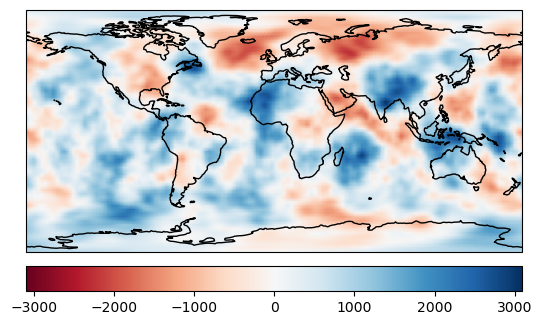

In [247]:
A.plot_from_grid(A.vector_to_grid(zeta_vec))